<a href="https://colab.research.google.com/github/ymuto0302/RW2025/blob/main/fine_tuning_ResNet%EF%BC%91%EF%BC%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet50 のファインチューニング
CIFAR-10 dataset のサブセットを対象に分類問題を解く。

（注意） 本コードの実行には GPU が必須である。

## 必要なライブラリのインポート

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import os

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## ハイパーパラメータの設定
事前学習によって得られた知識を破壊してしまわないよう，特に低い学習率を設定する点がポイント！！

In [2]:
# ハイパーパラメータ
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 1e-4 # 学習率を低めに設定する
WEIGHT_DECAY = 1e-4

## CIFAR-10 dataset の読み込み

In [3]:
# CIFAR-10データセットの読み込み
def load_cifar10_data(batch_size=32):
    # 訓練用変換
    train_transform = transforms.Compose([
        transforms.Resize(224),  # ResNetの入力サイズに合わせる
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # テスト用変換
    test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # === データセットの読み込み ===
    # (1) 元のデータセットの読み込み
    full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=train_transform)
    full_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=test_transform)

    # (2) サイズを小さくするため，サブセットを作成
    train_size = 10000  # 訓練データを 10000サンプルに
    test_size = 2000   # テストデータを 2000サンプルに
    # ランダムにインデックスを選択
    train_indices = torch.randperm(len(full_trainset))[:train_size]
    test_indices = torch.randperm(len(full_testset))[:test_size]

    # サブセットを作成
    trainset = Subset(full_trainset, train_indices)
    testset = Subset(full_testset, test_indices)

    # データローダーの構築
    trainloader = DataLoader(trainset, batch_size=batch_size,
                           shuffle=True, num_workers=2)

    testloader = DataLoader(testset, batch_size=batch_size,
                          shuffle=False, num_workers=2)

    return trainloader, testloader

# データセットを読み込み
print("データセットを読み込み中...")
trainloader, testloader = load_cifar10_data(batch_size=BATCH_SIZE)
print(f"訓練データ: {len(trainloader.dataset)}サンプル")
print(f"テストデータ: {len(testloader.dataset)}サンプル")

データセットを読み込み中...
訓練データ: 10000サンプル
テストデータ: 2000サンプル


## モデルの読み込み
ファインチューニングの場合，全てのモデル・パラメータを学習可能に設定する。

In [4]:
# ファインチューニング用のモデルを作成
def create_model(num_classes=10):

    # 事前学習済みResNet50をロード
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # 最終層を新しいタスク用に変更（CIFAR-10は 10クラス問題）
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # 全てのパラメータを学習可能に設定
    for param in model.parameters():
        param.requires_grad = True

    return model

# モデルを作成
model = create_model(num_classes=10)
model = model.to(device)

## モデルの訓練

In [5]:
# 1エポックの訓練
def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)

        # 勾配リセット
        optimizer.zero_grad()

        # 順伝播
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # 逆伝播とパラメータ更新
        loss.backward()
        optimizer.step()

        # 統計を更新
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return running_loss / len(trainloader), 100. * correct / total

# モデルの評価
def validate(model, testloader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss / len(testloader), 100. * correct / total

def train_model(epochs=10, learning_rate=1e-4, weight_decay=1e-4):
    # 損失関数と最適化アルゴリズムの定義
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # 訓練履歴を記録
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc = 0.0

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 30)

        # 訓練
        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)

        # 検証
        val_loss, val_acc = validate(model, testloader, criterion, device)

        # 履歴を記録
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # 最良モデルを保存
        if val_acc > best_acc:
            best_acc = val_acc

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Best Val Acc: {best_acc:.2f}%")

    return train_losses, train_accs, val_losses, val_accs

train_losses, train_accs, val_losses, val_accs = train_model(
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY)


Epoch 1/10
------------------------------


100%|██████████| 32/32 [00:03<00:00,  8.88it/s]


Train Loss: 0.6341, Train Acc: 79.88%
Val Loss: 0.3343, Val Acc: 89.65%
Best Val Acc: 89.65%

Epoch 2/10
------------------------------


100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


Train Loss: 0.1432, Train Acc: 96.31%
Val Loss: 0.2964, Val Acc: 90.20%
Best Val Acc: 90.20%

Epoch 3/10
------------------------------


100%|██████████| 32/32 [00:03<00:00,  8.78it/s]


Train Loss: 0.0370, Train Acc: 99.62%
Val Loss: 0.2874, Val Acc: 91.45%
Best Val Acc: 91.45%

Epoch 4/10
------------------------------


100%|██████████| 32/32 [00:03<00:00,  8.73it/s]


Train Loss: 0.0176, Train Acc: 99.85%
Val Loss: 0.2894, Val Acc: 91.55%
Best Val Acc: 91.55%

Epoch 5/10
------------------------------


100%|██████████| 32/32 [00:03<00:00,  9.19it/s]


Train Loss: 0.0133, Train Acc: 99.86%
Val Loss: 0.2978, Val Acc: 91.10%
Best Val Acc: 91.55%

Epoch 6/10
------------------------------


100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Train Loss: 0.0057, Train Acc: 99.99%
Val Loss: 0.2744, Val Acc: 91.40%
Best Val Acc: 91.55%

Epoch 7/10
------------------------------


100%|██████████| 32/32 [00:03<00:00,  8.31it/s]


Train Loss: 0.0041, Train Acc: 99.98%
Val Loss: 0.2796, Val Acc: 91.40%
Best Val Acc: 91.55%

Epoch 8/10
------------------------------


100%|██████████| 32/32 [00:03<00:00,  8.90it/s]


Train Loss: 0.0023, Train Acc: 100.00%
Val Loss: 0.2774, Val Acc: 92.10%
Best Val Acc: 92.10%

Epoch 9/10
------------------------------


100%|██████████| 32/32 [00:03<00:00,  9.01it/s]


Train Loss: 0.0015, Train Acc: 100.00%
Val Loss: 0.2782, Val Acc: 92.20%
Best Val Acc: 92.20%

Epoch 10/10
------------------------------


100%|██████████| 32/32 [00:04<00:00,  7.34it/s]

Train Loss: 0.0014, Train Acc: 100.00%
Val Loss: 0.2787, Val Acc: 92.05%
Best Val Acc: 92.20%


## 学習曲線

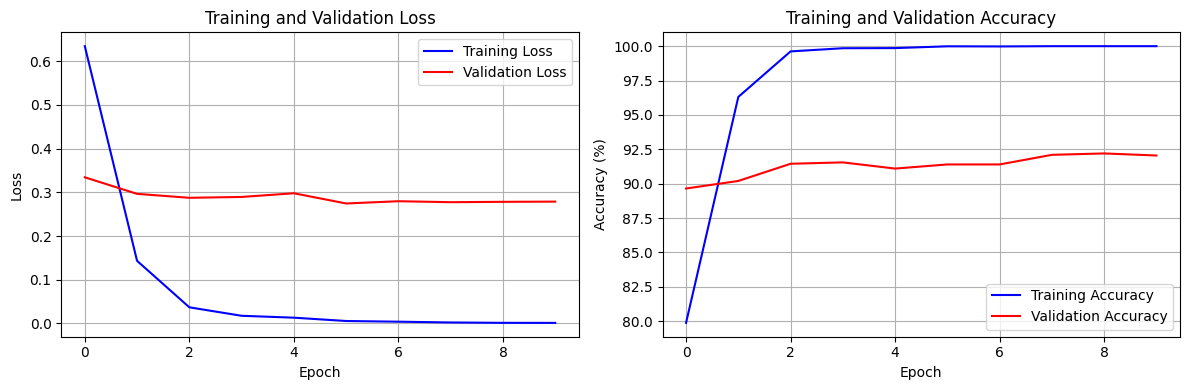

In [6]:
# 訓練履歴のプロット
def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy
    ax2.plot(train_accs, label='Training Accuracy', color='blue')
    ax2.plot(val_accs, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# 訓練履歴のプロット
plot_training_history(train_losses, train_accs, val_losses, val_accs)
